In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import csv
import os
from joblib import Parallel, delayed
from datetime import timedelta


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

base_dir = r'D:\Data\workspace\python\projects\CNDataAuditOutput\sichuan'
dataset_dir = rf'{base_dir}\datasets'
empties_dir = rf'{base_dir}\empty_datasets'
integrity_issues_dir = rf'{base_dir}\structural_issues_datasets'
catalog_path = rf'{base_dir}\dataset_catalog.json'
catalog_dtype = {'name': str, 'id': str, 'URL': str, 'owner': str, 'category': 'category',
                 'published': 'datetime64[ns]', 'updated': 'datetime64[ns]',
                 'frequency': 'category', 'sample_data': object}
null_values = ['无', '未知', '/', '-', '', ' ', '&nbsp;', 'null', 'NULL', 'N/A', ]
metrics = ['integrity', 'uniqueness', 'completeness', 'timeliness']

def read_csv(dataset_name, directory=dataset_dir):
    return pd.read_csv(dataset_file_path(dataset_name, directory),
                       encoding='gbk', na_values=null_values,
                       encoding_errors='ignore')

def dataset_file_path(filename: str, directory=dataset_dir):
    if not filename.endswith('.csv'):
        filename += '.csv'
    return os.path.join(directory, filename)

def exists(dataset_name, directory=dataset_dir):
    return os.path.exists(dataset_file_path(dataset_name, directory))

def dataset_files(directory=dataset_dir):
    return (f for f in os.listdir(directory) if f.endswith('.csv'))

def evaluate_metric(df, metric_function, *args):
    result = df.copy()
    result[metric_function.__name__] = result.apply(metric_function, axis=1, args=args)
    return result

def evaluate_metric_parallel(df, metric_function):
    result = df.copy()
    result[metric_function.__name__] = Parallel(n_jobs=-1)(
        delayed(metric_function)(name) for name in result['name'])
    return result

def pipeline(data, *funcs):
    result = data.copy()
    for func in funcs:
        result = func(result)
    return result

def autopct_format(values):
    def my_format(pct):
        val = int(round(pct * sum(values) / 100.0))
        return '{v:d} ({p:.2f}%)'.format(v=val, p=pct) if pct > 0 else ''
    return my_format

In [2]:
catalog_df = pd.read_json(catalog_path, dtype=catalog_dtype)
print(catalog_df.info())
print(catalog_df['category'].value_counts())
print(catalog_df['frequency'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777 entries, 0 to 3776
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         3777 non-null   object        
 1   id           3777 non-null   object        
 2   URL          3777 non-null   object        
 3   owner        3777 non-null   object        
 4   category     3777 non-null   category      
 5   published    3777 non-null   datetime64[ns]
 6   updated      3777 non-null   datetime64[ns]
 7   frequency    3777 non-null   category      
 8   sample_data  3776 non-null   object        
dtypes: category(2), datetime64[ns](2), object(5)
memory usage: 215.1+ KB
None
category
社保就业         946
医疗卫生         463
市场监管         360
生活服务         355
教育文化         234
生态环境         219
工业农业         189
公共安全         140
信用服务         132
财税金融         124
交通运输         110
城建住房         107
能源资源          80
社会救助          78
机构团体          53
商贸流通        

In [ ]:
def detect_conflicts(df):
    dataset_names_from_files = [os.path.splitext(f)[0] for f in dataset_files()]
    dataset_names_from_catalog = df['name'].tolist()
    datasets_not_in_catalog = set(dataset_names_from_files) - set(dataset_names_from_catalog)
    datasets_in_catalog_not_found = set(dataset_names_from_catalog) - set(dataset_names_from_files)
    
    print('Datasets not in catalog:', len(datasets_not_in_catalog))
    print('Datasets in catalog but not found in files:', len(datasets_in_catalog_not_found))
    return datasets_not_in_catalog, datasets_in_catalog_not_found

def remove_files(names):
    count = 0
    for dataset_name in names:
      if exists(dataset_name):
          os.remove(dataset_file_path(dataset_name))
          count += 1
      else:
          print(f"File not found: {dataset_file_path(dataset_name)}")
    print(count)

def remove_records(names, df):
    result = df[~df['name'].isin(names)]
    sample_data = result['sample_data'].copy()
    result = result.astype(str)
    result['sample_data'] = sample_data
    return result

def remove_conflicted_datasets(df):
    datasets_not_in_catalog, datasets_in_catalog_not_found = detect_conflicts(df)
    remove_files(datasets_not_in_catalog)
    return remove_records(datasets_in_catalog_not_found, df)

def remove_duplicated_datasets_by_name(df):
    duplicates = df[df.duplicated('name', keep=False)]
    print("Duplicate records based on 'name':",
          len(duplicates), duplicates['name'].sort_values())
    remove_files(set(duplicates['name'].tolist()))
    return remove_records(set(duplicates['name'].tolist()), df)


# filtered = pipeline(catalog_df, remove_conflicted_datasets,
#                     remove_duplicated_datasets_by_name)
# filtered.to_json('updated_catalog.json', orient='records', force_ascii=False)

In [ ]:
def move_empty_datasets(df):
    os.makedirs(empties_dir, exist_ok=True)
    is_empty_sample = df['sample_data'].apply(lambda x: x == {'null': 'null'})
    
    for index, row in df[is_empty_sample].iterrows():
        file_name = f'{row["name"]}.csv'
        if exists(file_name):
            source_path = dataset_file_path(file_name)
            destination_path = dataset_file_path(file_name)
            shutil.move(source_path, destination_path)
            print(f'Moved "{file_name}" to {empties_dir}')

move_empty_datasets(catalog_df)

In [3]:
def evaluate_csv_structural_integrity(df):
    return evaluate_metric_parallel(df, integrity)

def integrity(dataset_name):
    if exists(dataset_name, dataset_dir):
        return 1.0
    if exists(dataset_name, empties_dir):
        return np.nan

    csv_path = dataset_file_path(dataset_name, integrity_issues_dir)
    return count_good_rows(csv_path) / count_total_rows(csv_path)

def count_total_rows(file_path):
    try:
        with open(file_path, 'r', encoding='gbk', errors='ignore') as file:
            return sum(1 for _ in csv.reader(file))
    except IOError as e:
        print(f'Error reading file {file_path}: {e}')
        return 0

def count_good_rows(file_path):
    try:
        with open(file_path, 'r', encoding='gbk', errors='ignore') as file:
            reader = csv.reader(file)
            expected_columns = len(next(reader))
            return sum(1 for row in reader if len(row) == expected_columns)
    except IOError as e:
        print(f'Error reading file {file_path}: {e}')
        return 0

def move_structural_issues(destination_dir):
    os.makedirs(destination_dir, exist_ok=True)
    for file in dataset_files():
        if integrity(dataset_file_path(file)) != 1.0:
            shutil.move(dataset_file_path(file), dataset_file_path(file, directory=destination_dir))
            print(f"Moved '{dataset_file_path(file)}' to '{dataset_file_path(file, directory=destination_dir)}'")


move_structural_issues(integrity_issues_dir)
temp = evaluate_csv_structural_integrity(catalog_df)
temp['integrity'].value_counts(dropna=False).sort_index()


integrity
0.000000      11
0.000728       1
0.002899       1
0.004874       1
0.010576       1
0.219010       1
0.379310       1
0.653846       1
0.854962       1
0.882353       1
0.930693       1
0.933333       1
0.948393       1
0.953533       1
0.968780       1
0.982249       1
0.986928       1
0.988473       1
0.991342       1
0.992008       1
0.994006       2
0.994036       1
0.995015       1
0.997003       2
0.998002       3
1.000000    2972
NaN          766
Name: count, dtype: int64

In [4]:
def evaluate_uniqueness(df):
    return evaluate_metric_parallel(df, uniqueness)

def uniqueness(dataset_name):
    if not exists(dataset_name, dataset_dir):
        return np.nan
    return 0 if read_csv(dataset_name).duplicated().any() else 1


In [5]:
def evaluate_completeness(df):
    return evaluate_metric_parallel(df, completeness)

def completeness(dataset_name):
    def _completeness(dataset_df):
        return (dataset_df.size - dataset_df.isna().sum().sum()) / dataset_df.size
    
    return _completeness(read_csv(dataset_name)) if exists(dataset_name) else np.nan


temp = evaluate_completeness(catalog_df)
# temp['completeness'].hist()
temp['completeness'].value_counts(dropna=False).sort_index()

completeness
0.004000       2
0.006000       1
0.010345       1
0.016000       1
0.024000       1
            ... 
0.999938       2
0.999941       1
0.999957       1
1.000000    1385
NaN          805
Name: count, Length: 1092, dtype: int64

In [6]:
def evaluate_timeliness(df):
    downloaded = pd.Timestamp('2024-04-30 20:00:00')
    frequency_to_days = {'实时': 0, '每天': 1, '每周': 7, '每月': 30,
                         '每季度': 90, '每半年': 183, '每年': 365}
    return evaluate_metric(df, timeliness, downloaded, frequency_to_days)

def timeliness(dataset, now, days_map):
    days = days_map.get(dataset['frequency'], None)
    if days is None:
        return np.nan
    return 1.0 if now - dataset['updated'] <= timedelta(days=days) else 0.0

def timeliness_freq_distribution(df):
    timely_df = df[df['timeliness'] == 1.0]
    untimely_df = df[df['timeliness'] == 0.0]
    return timely_df['frequency'].value_counts(), untimely_df['frequency'].value_counts()

def print_timeliness_freq_distribution(df):
    timely_freq_counts, untimely_freq_counts = timeliness_freq_distribution(df)
    print('Frequency distribution for timely updates:')
    print(timely_freq_counts)
    print('Frequency distribution for untimely updates:')
    print(untimely_freq_counts)

def visualize_timeliness_distribution(df, save_path=None):
    timely_freq_counts, untimely_freq_counts = timeliness_freq_distribution(df)
    _timely_freq_counts = timely_freq_counts[timely_freq_counts > 0]
    _untimely_freq_counts = untimely_freq_counts[untimely_freq_counts > 0]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    axes[0].pie(_timely_freq_counts, labels=_timely_freq_counts.index,
                autopct=autopct_format(_timely_freq_counts), startangle=140)
    axes[1].pie(_untimely_freq_counts, labels=_untimely_freq_counts.index,
                autopct=autopct_format(_untimely_freq_counts), startangle=140)
    axes[0].set_title('及时更新的数据集更新频率分布')
    axes[1].set_title('未及时更新的数据集更新频率分布')
    fig.text(0.5, 0.01, '评估时间：2024-04-30 20:00:00', ha='center', va='bottom', fontsize=10)
    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


temp = evaluate_timeliness(catalog_df)
print_timeliness_freq_distribution(temp)
# visualize_timeliness_distribution(save_path='timeliness_distribution.png')
temp['timeliness'].value_counts(dropna=False)

Frequency distribution for timely updates:
frequency
每年     980
每半年     15
每月       1
不定期      0
实时       0
每周       0
每天       0
每季度      0
Name: count, dtype: int64
Frequency distribution for untimely updates:
frequency
每天     330
实时     246
每月     212
每半年    102
每季度     54
每周      18
每年       1
不定期      0
Name: count, dtype: int64


timeliness
NaN    1818
1.0     996
0.0     963
Name: count, dtype: int64

In [7]:
def evaluate_data_quality(df):
    return pipeline(df, evaluate_csv_structural_integrity,
                    evaluate_uniqueness, evaluate_completeness,
                    evaluate_timeliness)

def view(df):
    return df[['name', 'owner', 'category', 'integrity', 'uniqueness', 'completeness', 'timeliness', ]]

evaluated_df = evaluate_data_quality(catalog_df)

In [8]:
def analyze_data_quality(df):
    data_quality_df = view(df)

    print("Basic Statistics:")
    print(data_quality_df[metrics].describe())

    print("\nMissing Values Count:")
    print(data_quality_df[metrics].isnull().sum())

    print("\nValue Counts:")
    for metric in metrics:
        print(data_quality_df[metric].value_counts(dropna=False))

    print("\nProportion of Categories:")
    for metric in metrics:
        print(data_quality_df[metric].value_counts(dropna=False) / len(data_quality_df))


analyze_data_quality(evaluated_df)

Basic Statistics:
         integrity   uniqueness  completeness   timeliness
count  3011.000000  2972.000000   2972.000000  1959.000000
mean      0.994238     0.762786      0.916207     0.508423
std       0.072972     0.425446      0.158706     0.500057
min       0.000000     0.000000      0.004000     0.000000
25%       1.000000     1.000000      0.885830     0.000000
50%       1.000000     1.000000      0.999437     1.000000
75%       1.000000     1.000000      1.000000     1.000000
max       1.000000     1.000000      1.000000     1.000000

Missing Values Count:
integrity        766
uniqueness       805
completeness     805
timeliness      1818
dtype: int64

Value Counts:
integrity
1.000000    2972
NaN          766
0.000000      11
0.998002       3
0.997003       2
0.994006       2
0.653846       1
0.010576       1
0.000728       1
0.002899       1
0.994036       1
0.982249       1
0.219010       1
0.968780       1
0.854962       1
0.948393       1
0.986928       1
0.930693       1


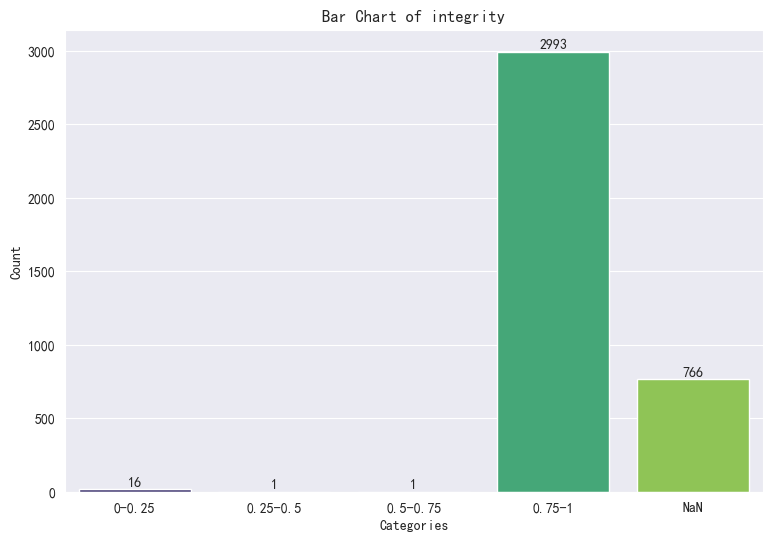

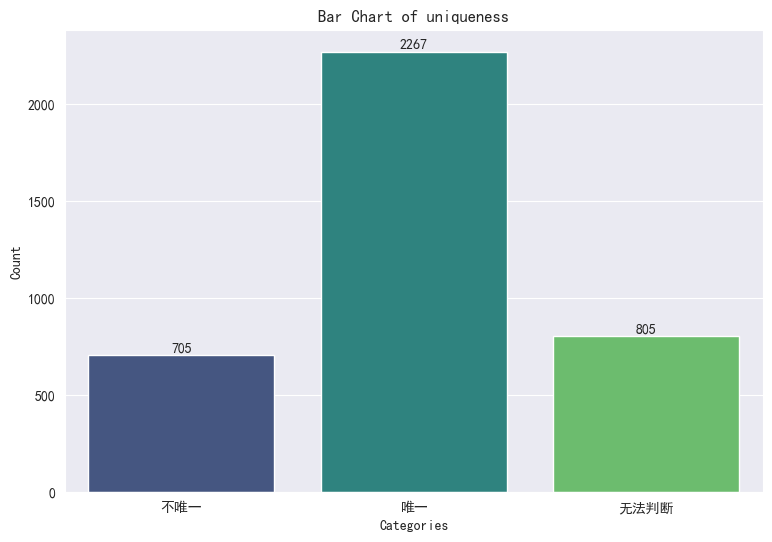

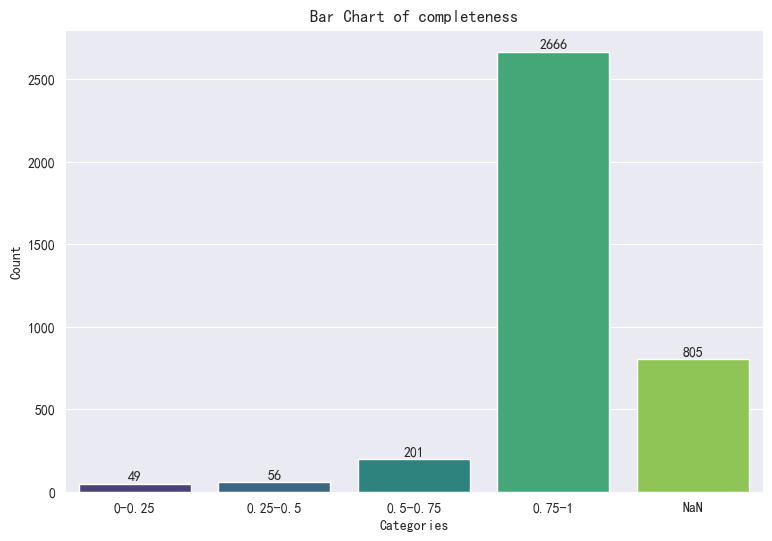

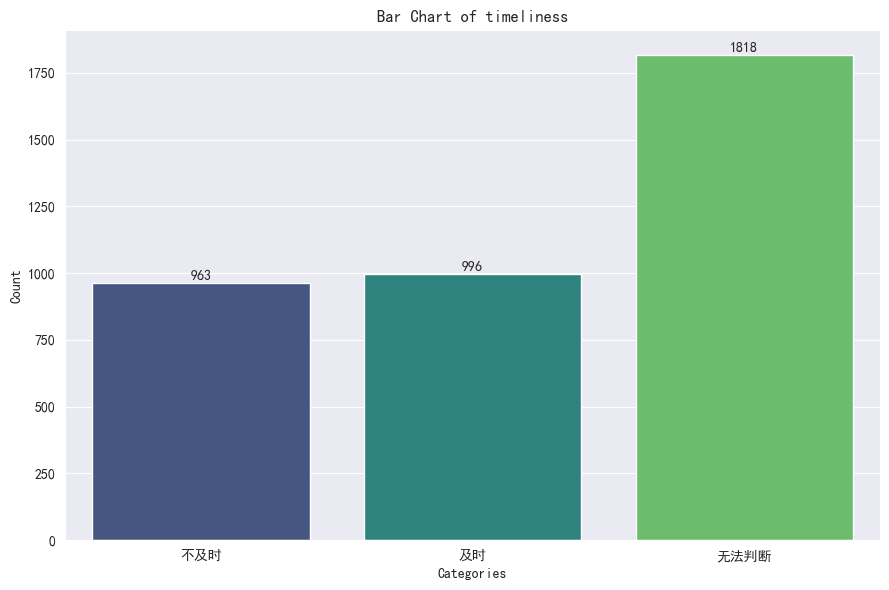

In [56]:
from collections import defaultdict


def visualize_data_quality(df, save_path=None):
    bins = (0, 0.25, 0.5, 0.75, 1)
    bin_labels = ('0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1', 'NaN')

    for i, metric in enumerate(metrics):
        _, ax = plt.subplots(figsize=(9, 6))
        if metric in ['integrity', 'completeness']:
            plot_category_chart(ax, metric, df.copy(), bins, bin_labels)
        else:
            plot_category_chart(ax, metric, df.copy())
        if save_path is not None:
            plt.savefig(f'{save_path}_{metric}.png')

    plt.tight_layout()
    plt.show()

def plot_category_chart(ax, column, df, bins=None, bin_labels=None):
    if bins and bin_labels:
        df['Category'] = pd.cut(df[column].dropna(), bins=bins, labels=bin_labels[:-1],
                                include_lowest=True)
        df['Category'] = df['Category'].astype(str)
        df.loc[df[column].isna(), 'Category'] = 'NaN'
    else:
        df['Category'] = df[column].map(label_dict_of(column)).fillna('NaN')

    sns.countplot(x='Category', data=df, ax=ax, palette='viridis', 
                  order=bin_labels if bins else sorted(df['Category'].unique()))
    ax.set_title(f'Bar Chart of {column}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

def label_dict_of(column):
    return defaultdict(lambda: '无法判断', {
        'integrity': {1.0: '正常', 0.0: '格式问题'},
        'completeness': {1.0: '完全', 0.0: '不完全'},
        'uniqueness': {1.0: '唯一', 0.0: '不唯一'},
        'timeliness': {1.0: '及时', 0.0: '不及时'}
    }.get(column, {}))


visualize_data_quality(evaluated_df, 'output')

In [13]:
type(evaluated_df.iloc[8]['uniqueness'])

numpy.float64

In [24]:
evaluated_df.sample()

,name,id,URL,owner,category,published,updated,frequency,sample_data,integrity,uniqueness,completeness,timeliness
3274,泸州市_泸县_个体工商户信息,e3ba89b7cd474c24982ab41a958a5c35,https://www.scdata.net.cn/oportal/catalog/e3ba...,泸县市场和质量监督管理局,生活服务,2023-04-14,2023-05-17,每年,{'null': 'null'},NaN,NaN,NaN,1.0
